# ResNet for CIFAR-10

We take the inspiration for this code from the github repository `pytorch-cifar`. It provides the basic block implementation of a Residual Network architecture. In our project, we declare a ResNet12 architecture, with four layers and `[2, 1, 1, 1]` blocks in each layer.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, dropout_rate=0.25):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(dropout_rate)  # Add dropout
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)  # Apply dropout after first activation
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, dropout_rate=0.5):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1, dropout_rate=dropout_rate)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2, dropout_rate=dropout_rate)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2, dropout_rate=dropout_rate)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2, dropout_rate=dropout_rate)
        self.dropout = nn.Dropout(dropout_rate)  # Add dropout before the final layer
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride, dropout_rate):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, dropout_rate))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)  # Apply dropout before the final fully connected layer
        out = self.linear(out)
        return out

def ResNet12():
    return ResNet(BasicBlock, [2, 1, 1, 1])


Next, we define a few helper functions to import the Kaggle dataset and format the training progress. Some are also taken from the `python-cifar` utility functions.

In [2]:
import os
import sys
import time
import math
import zipfile
import pickle
import torch.nn as nn
import torch.nn.init as init


term_width = 50
last_time = time.time()
begin_time = last_time

def progress_bar(current, total, msg=None):
    bar_length = 60
    progress = current / total

    block = int(round(bar_length * progress))
    # Use '>' as an arrow to indicate current progress position
    # Note: The arrow is positioned at the end of the filled portion, except when progress is 0
    arrow = ">" if block < bar_length else ""
    text = "\rProgress: [{0}{1}{2}] {3:.2f}% ({4}/{5}) {6}".format(
        "=" * (block - 1 if block > 0 else 0), arrow,
        "-" * (bar_length - block), progress * 100, current, total,
        msg if msg else "")
    sys.stdout.write(text)
    sys.stdout.flush()
    if current == total:
        sys.stdout.write('\n')

def format_time(seconds):
    days = int(seconds / 3600/24)
    seconds = seconds - days*3600*24
    hours = int(seconds / 3600)
    seconds = seconds - hours*3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes*60
    secondsf = int(seconds)
    seconds = seconds - secondsf
    millis = int(seconds*1000)

    f = ''
    i = 1
    if days > 0:
        f += str(days) + 'D'
        i += 1
    if hours > 0 and i <= 2:
        f += str(hours) + 'h'
        i += 1
    if minutes > 0 and i <= 2:
        f += str(minutes) + 'm'
        i += 1
    if secondsf > 0 and i <= 2:
        f += str(secondsf) + 's'
        i += 1
    if millis > 0 and i <= 2:
        f += str(millis) + 'ms'
        i += 1
    if f == '':
        f = '0ms'
    return f


def unpickle(filename):
    zf = zipfile.ZipFile(filename, "r")
    data = pickle.loads(zf.open("cifar_test_nolabels.pkl").read())
    zf.close()
    return data

Finally, we instanciate our model and count the number of parameters. We also import the CIFAR-10 dataset.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.nn.init as init

import torchvision
import torchvision.transforms as transforms

import os
import argparse
import sys
import time
import math

device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
combinedset = torch.utils.data.ConcatDataset([trainset, testset])

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)
combinedloader = torch.utils.data.DataLoader(
    combinedset, batch_size=128, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Model
print('==> Building model..')
net = ResNet12()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(net)
count_params = count_parameters(net)
print("Count params: ", count_params)
assert count_params < 5000000, "Parameters must be lower than 5 million"

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.5, inplace=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

# Training
For training, we use `CrossEntropyLoss` to measure how the model is doing as it is a multi-class classification task. Next, we use the `Adam` optimizer to train the parameters. The learning rate will be updated using cosine annealing scheduler.

In [4]:
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

# Loss
criterion = nn.CrossEntropyLoss()
# Training Optimizer
optimizer = optim.Adam(net.parameters())
# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# History
train_loss_hist = []
test_loss_hist = []

# Training
def train(epoch, dataloader):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        progress_bar(batch_idx+1, len(dataloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    
    # save the history
    train_loss_hist.append(train_loss)


def test(epoch, dataloader):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            progress_bar(batch_idx+1, len(dataloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                          % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # save the history
    test_loss_hist.append(test_loss)

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc

Do 25 epochs of training.

In [5]:
# Do 25 epoch
for epoch in range(start_epoch, start_epoch+25):
    train(epoch, trainloader)
    test(epoch, testloader)
    scheduler.step()


Epoch: 0
Progress: [===========================================================] 100.00% (391/391) Loss: 1.514 | Acc: 44.156% (22078/50000)
Progress: [===========================================================] 100.00% (100/100) Loss: 1.367 | Acc: 53.130% (5313/10000)
Saving..

Epoch: 1
Progress: [===========================================================] 100.00% (391/391) Loss: 1.101 | Acc: 60.414% (30207/50000)
Progress: [===========================================================] 100.00% (100/100) Loss: 1.006 | Acc: 64.490% (6449/10000)
Saving..

Epoch: 2
Progress: [===========================================================] 100.00% (391/391) Loss: 0.945 | Acc: 66.456% (33228/50000)
Progress: [===========================================================] 100.00% (100/100) Loss: 0.899 | Acc: 68.810% (6881/10000)
Saving..

Epoch: 3
Progress: [===========================================================] 100.00% (391/391) Loss: 0.854 | Acc: 69.702% (34851/50000)
Progress: [========

We can observe the loss over time.

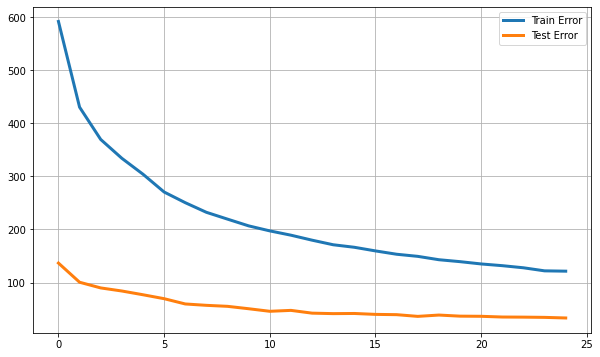

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))
plt.plot(train_loss_hist, '-', linewidth=3, label='Train Error')
plt.plot(test_loss_hist, '-', linewidth=3, label='Test Error')
plt.legend()
plt.grid(True)
plt.show()

Let's visualize the prediction performance on the test data.

In [7]:
from sklearn.metrics import confusion_matrix

labels = []
with torch.no_grad():
    for batch_idx, (input_test,label_test) in enumerate(testloader):
        input_test = input_test.to(device)
        outputs = net(input_test.float())
        _, predicted = outputs.max(1)
        labels.append(predicted)

# flatten the labels
pred = np.array([])
for batch in labels:
    pred = np.append(pred, batch.tolist())

# predict performance
cf_matrix = confusion_matrix(testset.targets, pred)
cf_matrix

array([[915,   8,  22,   8,   9,   1,   1,   2,  22,  12],
       [  7, 938,   1,   0,   0,   0,   2,   1,   8,  43],
       [ 26,   0, 876,  12,  22,  28,  27,   2,   4,   3],
       [ 13,   0,  55, 752,  36,  91,  34,  12,   4,   3],
       [  4,   0,  37,  11, 898,  13,  20,  17,   0,   0],
       [  4,   0,  22,  90,  26, 838,   6,  14,   0,   0],
       [ 12,   1,  32,  16,   7,   5, 922,   3,   2,   0],
       [ 10,   0,  12,  15,  28,  34,   3, 896,   2,   0],
       [ 33,   8,   3,   3,   0,   0,   0,   0, 941,  12],
       [  8,  32,   1,   4,   3,   0,   1,   3,  11, 937]])

From the confusion matrix, it looks like all labels have around 90% accuracy score. We see that label 3 ('cat') has the lowest accuracy of 75.2%. Let's look at some wrong prediction examples:

Files already downloaded and verified


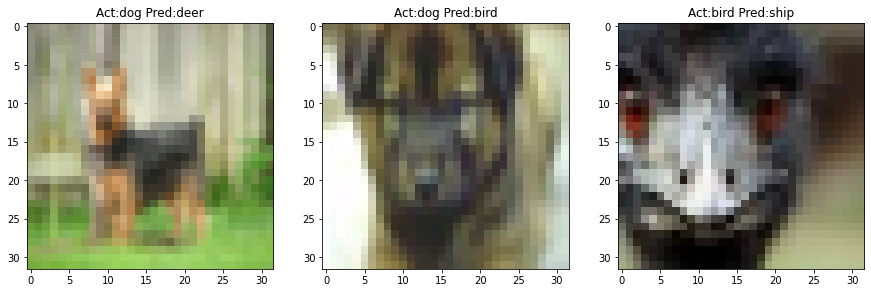

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

print_testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True)

fig, ax = plt.subplots(1, 3, figsize=(15, 10))
count = 0

for i in range(0, len(pred)):
    if print_testset.targets[i] != pred[i]:
        # print the image
        im = print_testset[i][0]
        ax[count].imshow(im)
        ax[count].set_title("Act:%s Pred:%s" % (classes[print_testset.targets[i]], classes[int(pred[i])]))
        count += 1

    if count == 3:
        break

plt.show()

For our best result, we trained the model using the combined dataset for 100 epochs with the RTX8000 GPU in NYU's HPC cluster.

In [9]:
# Do 100 epoch
for epoch in range(start_epoch, start_epoch+100):
    train(epoch, combinedloader)
    test(epoch, testloader)
    scheduler.step()


Epoch: 0
Progress: [===========================================================] 100.00% (469/469) Loss: 0.319 | Acc: 88.993% (53396/60000)
Progress: [===========================================================] 100.00% (100/100) Loss: 0.220 | Acc: 92.520% (9252/10000)
Saving..

Epoch: 1
Progress: [===========================================================] 100.00% (469/469) Loss: 0.299 | Acc: 89.637% (53782/60000)
Progress: [===========================================================] 100.00% (100/100) Loss: 0.203 | Acc: 92.860% (9286/10000)
Saving..

Epoch: 2
Progress: [===========================================================] 100.00% (469/469) Loss: 0.286 | Acc: 90.023% (54014/60000)
Progress: [===========================================================] 100.00% (100/100) Loss: 0.146 | Acc: 95.160% (9516/10000)
Saving..

Epoch: 3
Progress: [===========================================================] 100.00% (469/469) Loss: 0.276 | Acc: 90.288% (54173/60000)
Progress: [========

Progress: [===========================================================] 100.00% (100/100) Loss: 0.002 | Acc: 99.980% (9998/10000)

Epoch: 59
Progress: [===========================================================] 100.00% (469/469) Loss: 0.093 | Acc: 96.728% (58037/60000)
Progress: [===========================================================] 100.00% (100/100) Loss: 0.002 | Acc: 99.990% (9999/10000)

Epoch: 60
Progress: [===========================================================] 100.00% (469/469) Loss: 0.092 | Acc: 96.783% (58070/60000)
Progress: [===========================================================] 100.00% (100/100) Loss: 0.002 | Acc: 100.000% (10000/10000)

Epoch: 61
Progress: [===========================================================] 100.00% (469/469) Loss: 0.089 | Acc: 96.823% (58094/60000)
Progress: [===========================================================] 100.00% (100/100) Loss: 0.002 | Acc: 99.990% (9999/10000)

Epoch: 62
Progress: [==============================

# Prediction
For the Kaggle data prediction, we will import the trained model and start predicting.

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.nn.init as init

import torchvision
import torchvision.transforms as transforms

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Model
print('==> Building model..')
net = ResNet12()
net = net.to(device)
net = torch.nn.DataParallel(net)
if device == 'cuda':
    cudnn.benchmark = True

# load state
saved_model = torch.load('./checkpoint/ckpt.pth', map_location=torch.device(device))
net.load_state_dict(saved_model['net'])
net.eval()

==> Building model..


DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.5, inplace=False)
    

Preprocess the raw data and predict in batches of a thousand.

In [11]:
import numpy as np
from PIL import Image

cifar_test_nolabels = unpickle("../data/cifar_test_nolabels.pkl.zip")
competition_data = cifar_test_nolabels[b'data']
y_id = cifar_test_nolabels[b'ids']

competitionset = []
for d in competition_data:
    # transpose flatten CIFAR image to RGB
    d = d.reshape(3, 32, 32).transpose(1,2,0)
    im = Image.fromarray(d, mode='RGB')
    im = transform_test(im)
    competitionset.append(im)

competitionloader = torch.utils.data.DataLoader(
    competitionset, batch_size=1000, shuffle=False)

labels = []

def competition_test():
    net.eval()
    
    with torch.no_grad():
        for batch_idx, input_test in enumerate(competitionloader):
            input_test = input_test.to(device)
            outputs = net(input_test.float())
            _, predicted = outputs.max(1)
            labels.append(predicted)
            print("Batch %d done" % (batch_idx + 1))

            
competition_test()

Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done


Finally, we write the prediction labels into a .csv file for submission.

In [12]:
import pandas as pd

# flatten the labels
pred = np.array([])
for batch in labels:
    pred = np.append(pred, batch.tolist())


competition_data_ids = unpickle("../data/cifar_test_nolabels.pkl.zip")[b'ids']
    
# create dataframe to save prediction
df = pd.DataFrame()
df['ID'] = competition_data_ids
df['Label'] = pred
df['Label'] = df['Label'].astype(int)

df.to_csv('out.csv', index=False)